In [ ]:
# STEP 8
# Topic Overview Table
# input: topic_summary_mts30_fast.csv

import pandas as pd

ts = pd.read_csv("topic_summary_mts30_fast.csv")

# Standardize to: topic, name, count (works whether your file has Topic/Name/Count or lowercase)
colmap = {}
for c in ts.columns:
    lc = c.strip().lower()
    if lc == "topic": colmap[c] = "topic"
    if lc == "name":  colmap[c] = "name"
    if lc == "count": colmap[c] = "count"
ts = ts.rename(columns=colmap)

missing = {"topic","name","count"} - set(ts.columns)
if missing:
    raise ValueError(f"Your file is missing expected columns: {missing}. "
                     f"Found columns: {list(ts.columns)}")

# drop the outlier/topic -1 if present
#if (-1 in ts["topic"].values):
 #   ts = ts[ts["topic"] != -1]

# Sort by size
ts = ts.sort_values("count", ascending=False)

# Preview
display(ts[["topic","name","count"]].head(30))



,topic,name,count
0,-1,-1_israel_jews_palestinians_hamas,60923
1,0,0_genocide_comments_israel_hamas,26251
2,1,1_woman_vote_party_hope,1516
3,2,2_debate_argument_evidence_comment,1214
4,3,3_avoid_contact_performed_automatically,1042
5,4,4_british_english_love_language,427
6,5,5_happen_happened_unfortunately_haven,287
7,6,6_source_sources_article_link,279
8,7,7_carefully_content_join_removed,258
9,8,8_users_user_rule_fellow,230


In [ ]:
#Read a Few Example Posts per Topic
# Save examples for the exact same Top-30 topics used in your bar chart
# (mirrors the same filtering & ordering)

import re
from pathlib import Path
from datetime import datetime
import pandas as pd

# CONFIG 
TOPIC_SUMMARY_CSV  = "topic_summary_mts30_fast.csv"
PER_DOC_CSV        = "topics_per_doc_mts30_fast.csv"
MODEL_TAG          = "mts30"
TOP_N_BARS         = 30
N_PER_TOPIC        = 50   # how many examples per topic
SEED               = 42
DROP_JUNK_TOPICS   = True  # same as viz code

OUT_DIR = Path(f"topic_examples_top{TOP_N_BARS}_{MODEL_TAG}")
OUT_DIR.mkdir(exist_ok=True)

#Load & standardize 
ts = pd.read_csv(TOPIC_SUMMARY_CSV)

def stdcol(df):
    cmap = {}
    for c in df.columns:
        lc = c.strip().lower()
        if lc in {"topic","name","count"}:
            cmap[c] = lc
    out = df.rename(columns=cmap)
    miss = {"topic","name","count"} - set(out.columns)
    if miss:
        raise ValueError(f"Expected topic/name/count in {TOPIC_SUMMARY_CSV}. Missing: {miss}. Found: {list(df.columns)}")
    return out

ts = stdcol(ts)

# drop outlier topic -1 if present
#if (-1 in ts["topic"].values):
 #   ts = ts[ts["topic"] != -1].copy()

# drop junk topics by name (same rule as viz)
if DROP_JUNK_TOPICS:
    junk_pat = re.compile(r"\b(deleted|removed|null|nan)\b", flags=re.IGNORECASE)
    ts = ts[~ts["name"].fillna("").str.contains(junk_pat)].copy()

# order by size and pick Top-N (this is the exact bar chart ordering)
ts = ts.sort_values("count", ascending=False).reset_index(drop=True)
topN = ts.head(TOP_N_BARS).copy()

# Save an index of the selected topics (ranked)
index_path = OUT_DIR / f"top{TOP_N_BARS}_topics_index_{MODEL_TAG}.csv"
idx = topN.assign(rank=range(1, len(topN)+1))[["rank","topic","name","count"]]
idx.to_csv(index_path, index=False)
print(f"✓ wrote topic index → {index_path}")

# Load per-doc assignments and align columns
docs = pd.read_csv(PER_DOC_CSV, low_memory=False)

# unify column names
docs = docs.rename(columns={
    **{c: "topic" for c in docs.columns if c.strip().lower()=="topic"},
    **{c: "text"  for c in docs.columns if c.strip().lower() in {"clean_for_topics","text"}}
})
if "topic" not in docs.columns:
    raise ValueError(f"'topic' column not found in {PER_DOC_CSV}")

# choose best available text column if 'text' still missing
if "text" not in docs.columns:
    for cand in ["clean_for_topics","selftext","body","title"]:
        if cand in docs.columns:
            docs["text"] = docs[cand].astype(str)
            break
    if "text" not in docs.columns:
        raise ValueError(f"No usable text column found in {PER_DOC_CSV}")

# keep only selected topics (same set as bar chart)
keep_ids = set(topN["topic"].tolist())
docs = docs[docs["topic"].isin(keep_ids)].copy()

# build a name map for pretty output
name_map = dict(zip(ts["topic"], ts["name"]))

# Helper: save per-topic CSV + TXT 
def save_examples_for_topic(tid: int, n: int = 50, seed: int = 42) -> int:
    sub = docs[docs["topic"] == tid].copy()
    if sub.empty:
        print(f"[warn] topic {tid}: 0 docs — skipped.")
        return 0
    n_pick = min(n, len(sub))
    sample = sub.sample(n_pick, random_state=seed).copy()

    # choose columns to export if present
    cols = ["id","subreddit","kind","dt","score","topic","text"]
    # attach auto-name as 'topic_name' for convenience
    sample["topic_name"] = name_map.get(tid, "")
    cols = [c for c in cols if c in sample.columns] + ["topic_name"]
    sample = sample[cols]

    # filename slug
    raw_name = str(name_map.get(tid, f"topic_{tid}"))
    short = re.sub(r"^\d+_", "", raw_name)
    slug = re.sub(r"[^a-z0-9]+", "_", short.lower()).strip("_")[:60]

    csv_path = OUT_DIR / f"topic{tid:03d}_{slug}.csv"
    txt_path = OUT_DIR / f"topic{tid:03d}_{slug}.txt"

    # CSV
    sample.to_csv(csv_path, index=False, encoding="utf-8")

    # TXT (pretty)
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(f"# Topic {tid} — {raw_name}\n")
        f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
        f.write(f"Examples: {n_pick}\n\n")
        for i, row in sample.iterrows():
            header_bits = []
            for k in ["id","subreddit","kind","dt","score"]:
                if k in sample.columns and pd.notna(row.get(k, None)):
                    header_bits.append(f"{k}: {row[k]}")
            header = " | ".join(header_bits) or f"Example {i+1}"
            f.write(f"--- {header} ---\n")
            f.write(str(row["text"]).strip() + "\n\n")

    print(f"✓ topic {tid:3d}: saved {n_pick} → {csv_path.name}, {txt_path.name}")
    return n_pick

# Save for each topic in bar order (rank order)
total = 0
for tid in topN["topic"].tolist():
    total += save_examples_for_topic(tid, n=N_PER_TOPIC, seed=SEED)

print(f"\n[done] Saved {total} rows across {len(topN)} topics → {OUT_DIR.resolve()}")


C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:46: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ts = ts[~ts["name"].fillna("").str.contains(junk_pat)].copy()


✓ wrote topic index → topic_examples_top30_mts30\top30_topics_index_mts30.csv


C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\M

✓ topic   0: saved 50 → topic000_genocide_comments_israel_hamas.csv, topic000_genocide_comments_israel_hamas.txt
✓ topic   1: saved 50 → topic001_woman_vote_party_hope.csv, topic001_woman_vote_party_hope.txt
✓ topic   2: saved 50 → topic002_debate_argument_evidence_comment.csv, topic002_debate_argument_evidence_comment.txt
✓ topic   3: saved 50 → topic003_avoid_contact_performed_automatically.csv, topic003_avoid_contact_performed_automatically.txt
✓ topic   4: saved 50 → topic004_british_english_love_language.csv, topic004_british_english_love_language.txt
✓ topic   5: saved 50 → topic005_happen_happened_unfortunately_haven.csv, topic005_happen_happened_unfortunately_haven.txt
✓ topic   6: saved 50 → topic006_source_sources_article_link.csv, topic006_source_sources_article_link.txt
✓ topic   7: saved 50 → topic007_carefully_content_join_removed.csv, topic007_carefully_content_join_removed.txt
✓ topic   8: saved 50 → topic008_users_user_rule_fellow.csv, topic008_users_user_rule_fellow.t

C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\M

✓ topic  12: saved 50 → topic012_thank_sharing_welcome_heart.csv, topic012_thank_sharing_welcome_heart.txt
✓ topic  13: saved 50 → topic013_history_historical_facts_book.csv, topic013_history_historical_facts_book.txt
✓ topic  14: saved 50 → topic014_banned_ban_account_sub.csv, topic014_banned_ban_account_sub.txt
✓ topic  15: saved 50 → topic015_tiktok_ban_app_trump.csv, topic015_tiktok_ban_app_trump.txt
✓ topic  16: saved 50 → topic016_propaganda_conspiracy_spread_truth.csv, topic016_propaganda_conspiracy_spread_truth.txt
✓ topic  17: saved 50 → topic017_left_liberal_leftist_wing.csv, topic017_left_liberal_leftist_wing.txt
✓ topic  18: saved 50 → topic018_ukraine_russia_russian_russians.csv, topic018_ukraine_russia_russian_russians.txt
✓ topic  19: saved 50 → topic019_google_search_ad_boycott.csv, topic019_google_search_ad_boycott.txt
✓ topic  20: saved 50 → topic020_food_israeli_eat_woman.csv, topic020_food_israeli_eat_woman.txt
✓ topic  21: saved 50 → topic021_international_law_law_

C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\2512072509.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Saved: {datetime.utcnow().isoformat()}Z\n")
C:\Users\M

In [ ]:
#top 10 words for each topic

import pandas as pd

TOPIC_SUMMARY_CSV = "topic_summary_mts30_fast.csv"  # <-- change if needed
TOP_N = 10
INCLUDE_OUTLIER = False  # set True to include topic -1

# Load & normalize column names
ts = pd.read_csv(TOPIC_SUMMARY_CSV)
ts = ts.rename(columns={"Topic": "topic", "Name": "name", "Count": "count", "Size": "count"})
if "count" not in ts.columns:
    # some exports use lowercase already; nothing to do
    pass

# Sort by size (largest first) if available
if "count" in ts.columns:
    ts = ts.sort_values("count", ascending=False)

def parse_words(name: str):
    """Parse BERTopic's 'name' like '3_hamas_israel_gaza...' -> ['hamas','israel','gaza', ...]."""
    if not isinstance(name, str):
        return []
    parts = name.split("_", 1)
    words = parts[1].split("_") if len(parts) > 1 else name.split("_")
    # light clean: drop empties/1-char
    words = [w.strip() for w in words if isinstance(w, str) and w.strip() and len(w.strip()) > 1]
    return words

# Print top-N words for each topic
print("\nTop words per topic (parsed from 'name'):\n")
for _, row in ts.iterrows():
    tid = row.get("topic", "?")
    cnt = row.get("count", None)
    words = parse_words(row.get("name", ""))
    header = f"[Topic {tid}]"
    if pd.notna(cnt):
        header += f" (count={int(cnt):,})"
    print(header)
    print("  " + ", ".join(words[:TOP_N]))
    print()



Top words per topic (parsed from 'name'):

[Topic 0] (count=26,251)
  genocide, comments, israel, hamas

[Topic 1] (count=1,516)
  woman, vote, party, hope

[Topic 2] (count=1,214)
  debate, argument, evidence, comment

[Topic 3] (count=1,042)
  avoid, contact, performed, automatically

[Topic 4] (count=427)
  british, english, love, language

[Topic 5] (count=287)
  happen, happened, unfortunately, haven

[Topic 6] (count=279)
  source, sources, article, link

[Topic 7] (count=258)
  carefully, content, join, removed

[Topic 8] (count=230)
  users, user, rule, fellow

[Topic 9] (count=211)
  boycott, brand, company, companies

[Topic 10] (count=207)
  allah, protect, beautiful, god

[Topic 11] (count=204)
  release, held, released, taken

[Topic 12] (count=199)
  thank, sharing, welcome, heart

[Topic 13] (count=179)
  history, historical, facts, book

[Topic 14] (count=151)
  banned, ban, account, sub

[Topic 15] (count=150)
  tiktok, ban, app, trump

[Topic 16] (count=148)
  propag

C:\Users\Matilde\AppData\Local\Temp\ipykernel_14728\385703029.py:60: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ts = ts[~ts["name"].fillna("").str.contains(junk_pat)].copy()


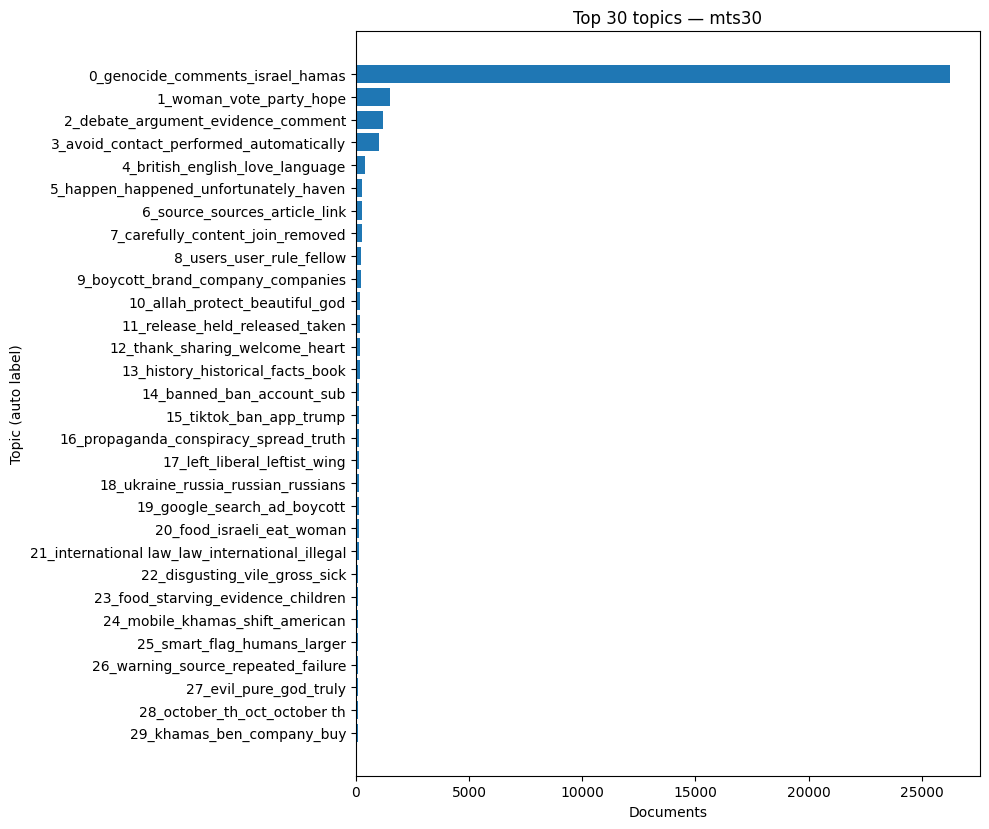

✓ saved bar chart → topic_barchart_top30_mts30.png


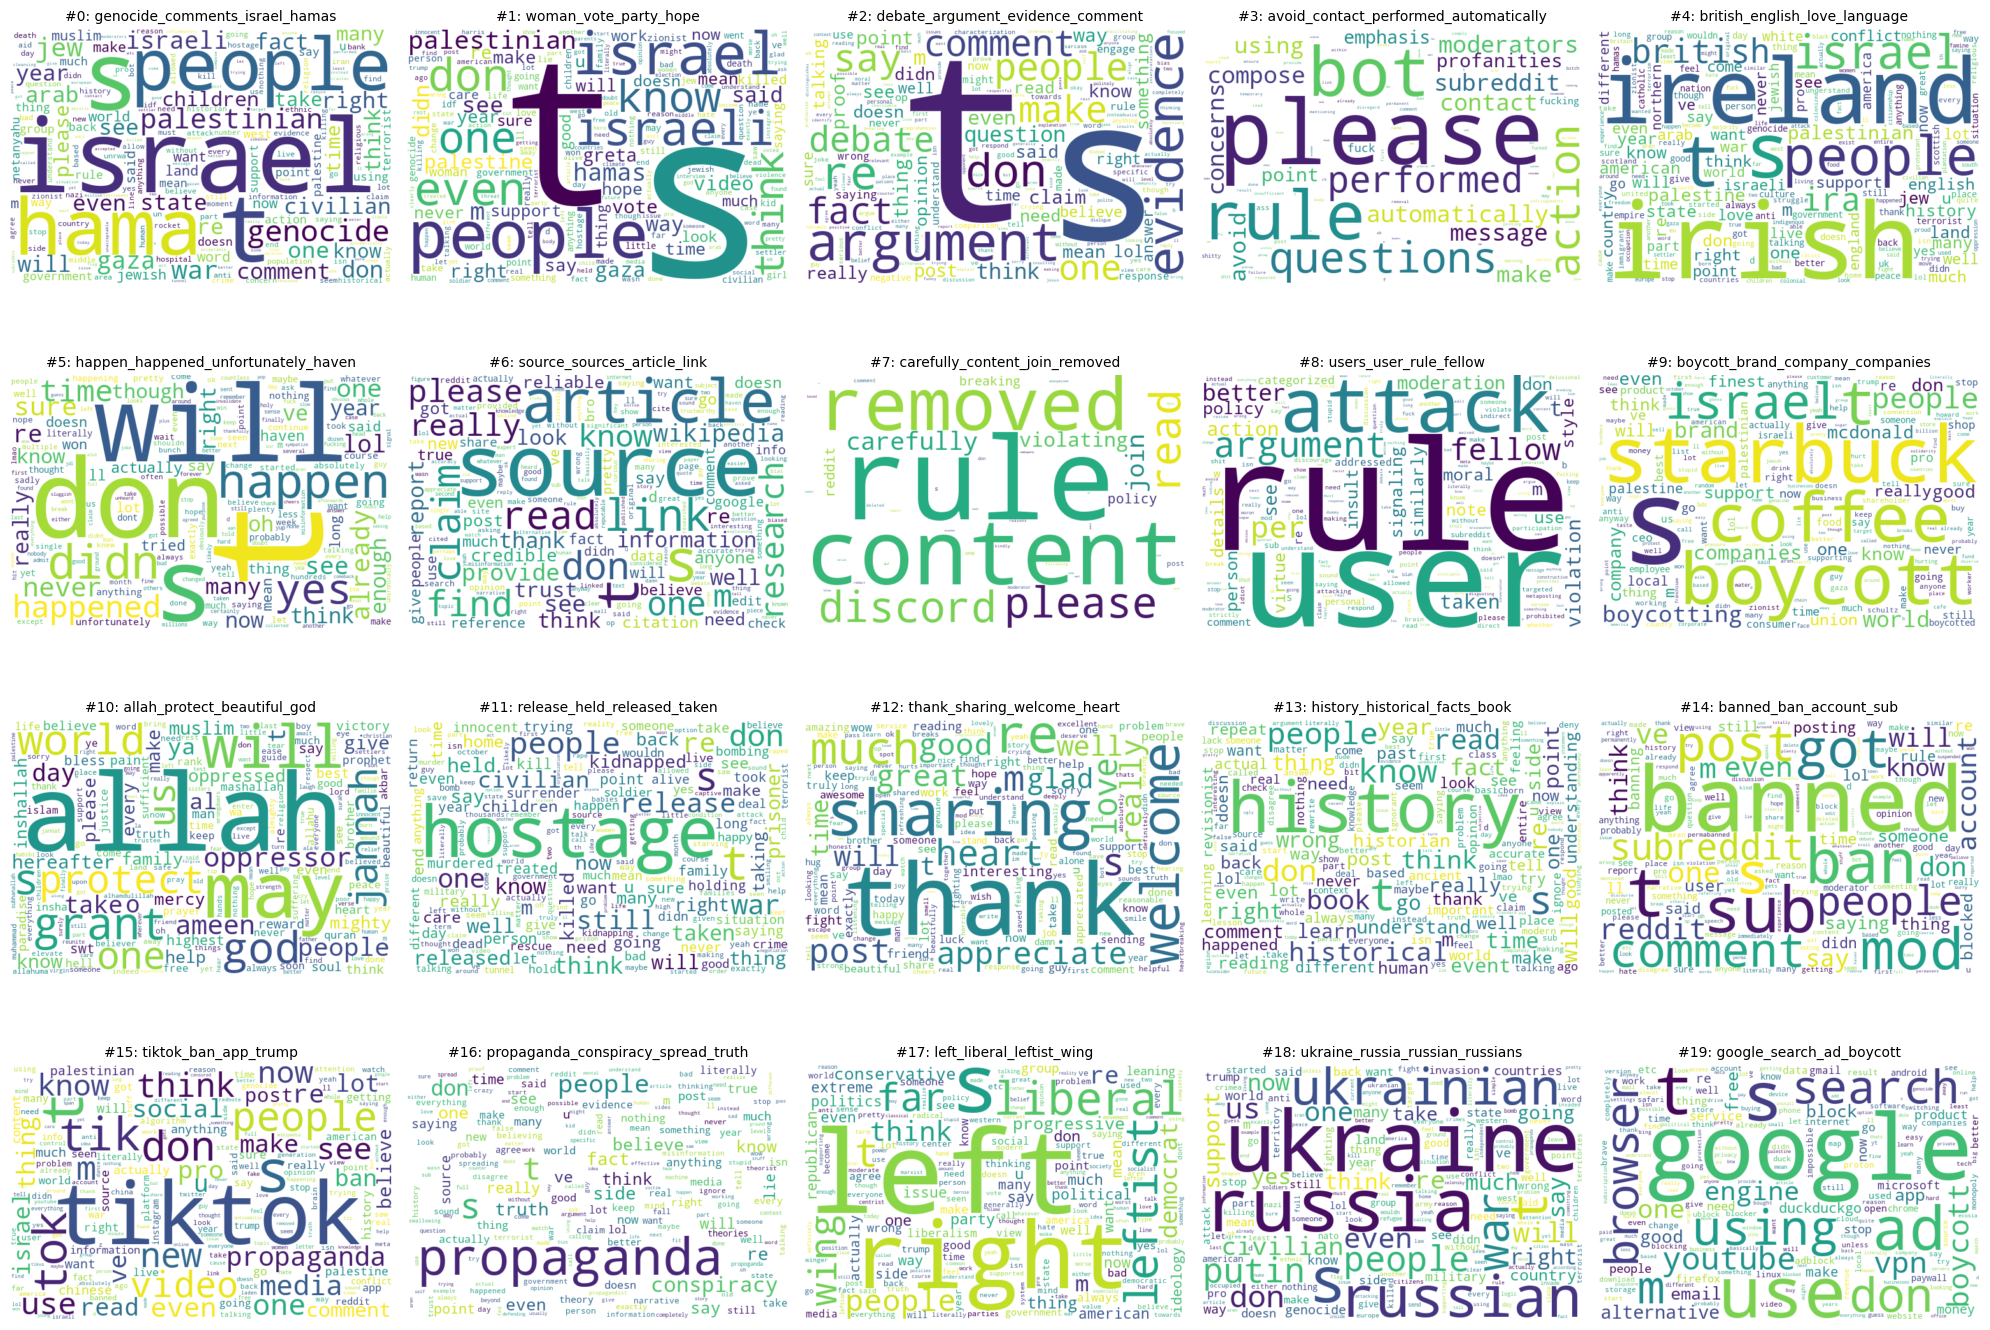

✓ saved wordcloud grid → wordclouds_grid_mts30.png
✓ saved individual wordclouds → wordclouds_mts30/


In [ ]:
# Visualize BERTopic results: bar charts + wordclouds
# Inputs:
#   - topic_summary_mts30_fast.csv         (topics with counts + names)
#   - topics_per_doc_mts30_fast.csv        (each doc with 'topic' + text)
#
# Outputs:
#   - topic_barchart_top30_mts30.png       (bar chart of largest topics)
#   - wordclouds_grid_mts30.png            (grid of wordclouds for top topics)
#   - wordclouds_mts30/<topic>_<slug>.png  (optional: individual wordclouds)

import os, re, math
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# install wordcloud if missing
try:
    from wordcloud import WordCloud
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud

# CONFIG
TOPIC_SUMMARY_CSV  = "topic_summary_mts30_fast.csv"
PER_DOC_CSV        = "topics_per_doc_mts30_fast.csv"
MODEL_TAG          = "mts30"          # used in file names
TOP_N_BARS         = 30               # bar chart: how many topics
TOP_N_WORDCLOUDS   = 20               # wordcloud grid: how many topics
MAX_DOCS_PER_TOPIC = 400              # sample per topic for wordcloud text
DROP_JUNK_TOPICS   = True             # filter topics named 'deleted/removed/nan...' from visuals
INDIVIDUAL_WC      = True             # also export each wordcloud as its own PNG

# LOAD & STANDARDIZE COLUMNS
ts = pd.read_csv(TOPIC_SUMMARY_CSV)
def stdcol(df):
    # rename Topic/Name/Count -> topic/name/count if needed
    cmap = {}
    for c in df.columns:
        lc = c.strip().lower()
        if lc in {"topic", "name", "count"}:
            cmap[c] = lc
    out = df.rename(columns=cmap)
    # sanity
    missing = {"topic","name","count"} - set(out.columns)
    if missing:
        raise ValueError(f"Expected topic/name/count in {TOPIC_SUMMARY_CSV}. Missing: {missing}. Found: {list(df.columns)}")
    return out

ts = stdcol(ts)

# optional: drop junky topics by their auto-name
if DROP_JUNK_TOPICS:
    junk_pat = re.compile(r"\b(deleted|removed|null|nan)\b", flags=re.IGNORECASE)
    ts = ts[~ts["name"].fillna("").str.contains(junk_pat)].copy()

ts = ts.sort_values("count", ascending=False).reset_index(drop=True)

docs = pd.read_csv(PER_DOC_CSV, low_memory=False)
# standardize key columns
docs = docs.rename(columns={
    **{c: "topic" for c in docs.columns if c.strip().lower()=="topic"},
    **{c: "text"  for c in docs.columns if c.strip().lower() in {"clean_for_topics","text"}}
})
if "topic" not in docs.columns:
    raise ValueError(f"'topic' column not found in {PER_DOC_CSV}")
if "text" not in docs.columns:
    # fallback to body/selftext/title if available
    for cand in ["body","selftext","title"]:
        if cand in docs.columns:
            docs["text"] = docs[cand].astype(str)
            break
    if "text" not in docs.columns:
        raise ValueError(f"No text column found in {PER_DOC_CSV}")

# keep only topics that remain after filtering
keep_topics = set(ts["topic"].tolist())
docs = docs[docs["topic"].isin(keep_topics)].copy()

# 1) BAR CHART (Top N topics)
top_bar = ts.head(TOP_N_BARS).copy()
fig, ax = plt.subplots(figsize=(10, max(6, TOP_N_BARS*0.28)))
ax.barh(top_bar["name"][::-1], top_bar["count"][::-1])
ax.set_xlabel("Documents")
ax.set_ylabel("Topic (auto label)")
ax.set_title(f"Top {TOP_N_BARS} topics — {MODEL_TAG}")
plt.tight_layout()
bar_path = f"topic_barchart_top{TOP_N_BARS}_{MODEL_TAG}.png"
plt.savefig(bar_path, dpi=200)
plt.show()
print(f"✓ saved bar chart → {bar_path}")

# 2) WORDCLOUDS (Top N topics)
# Build a text blob for each topic from sample docs
def clean_min(t):
    if not isinstance(t, str):
        return ""
    # light clean for WC
    t = t.lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"&amp;", "&", t)
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def gather_text_for_topic(topic_id, n=MAX_DOCS_PER_TOPIC):
    sub = docs[docs["topic"] == topic_id]
    if len(sub) == 0:
        return ""
    # sample to cap runtime/memory
    sub = sub.sample(min(n, len(sub)), random_state=0)
    return " ".join(clean_min(x) for x in sub["text"].astype(str).tolist())

# Create wordclouds for top topics
top_wc = ts.head(TOP_N_WORDCLOUDS).copy()
wc_texts = {}
for _, row in top_wc.iterrows():
    tid, name = int(row["topic"]), str(row["name"])
    wc_texts[tid] = (name, gather_text_for_topic(tid, MAX_DOCS_PER_TOPIC))

# individual exports
out_dir = Path(f"wordclouds_{MODEL_TAG}")
if INDIVIDUAL_WC:
    out_dir.mkdir(parents=True, exist_ok=True)

# grid figure
cols = 5
rows = math.ceil(TOP_N_WORDCLOUDS/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.0, rows*3.6))
axes = np.array(axes).reshape(rows, cols)

for i, (tid, (name, text)) in enumerate(wc_texts.items()):
    r, c = divmod(i, cols)
    ax = axes[r, c]
    if text.strip():
        wc = WordCloud(width=600, height=400, background_color="white", collocations=False).generate(text)
        ax.imshow(wc, interpolation="bilinear")
    else:
        ax.text(0.5, 0.5, "No text", ha="center", va="center", fontsize=12)
        ax.set_facecolor("white")
    ax.axis("off")
    # short label
    short = re.sub(r"^\d+_", "", name)
    short = (short[:50] + "…") if len(short) > 50 else short
    ax.set_title(f"#{tid}: {short}", fontsize=10)
    if INDIVIDUAL_WC and text.strip():
        slug = re.sub(r"[^a-z0-9]+", "_", short.lower()).strip("_")
        wc_path = out_dir / f"topic{tid}_{slug}.png"
        wc.to_file(str(wc_path))

# blank any extra cells
for j in range(len(wc_texts), rows*cols):
    r, c = divmod(j, cols)
    axes[r, c].axis("off")

plt.tight_layout()
grid_path = f"wordclouds_grid_{MODEL_TAG}.png"
plt.savefig(grid_path, dpi=200)
plt.show()
print(f"✓ saved wordcloud grid → {grid_path}")
if INDIVIDUAL_WC:
    print(f"✓ saved individual wordclouds → {out_dir}/")
